Gentlewake Data Analysis
Session: 91.3 minutes, 15.1 Hz
Window size: 30 seconds (452 samples)

Personalized thresholds from this session:
Lower activity threshold (25th percentile): 0.000051
Higher activity threshold (75th percentile): 0.000068

Session Summary:
Duration: 91.3 minutes
Data points: 82,650
Movement range: 2.378 g
Temperature range: 7.710 C

Movement Variance Analysis:
Range: 0.000040 to 0.024281
Ratio: 603.6x difference

Activity Pattern Distribution:
Moderate Activity: 90 windows (49.5%)
Lower Activity: 46 windows (25.3%)
Higher Activity (Rising Temp): 31 windows (17.0%)
Higher Activity: 15 windows (8.2%)


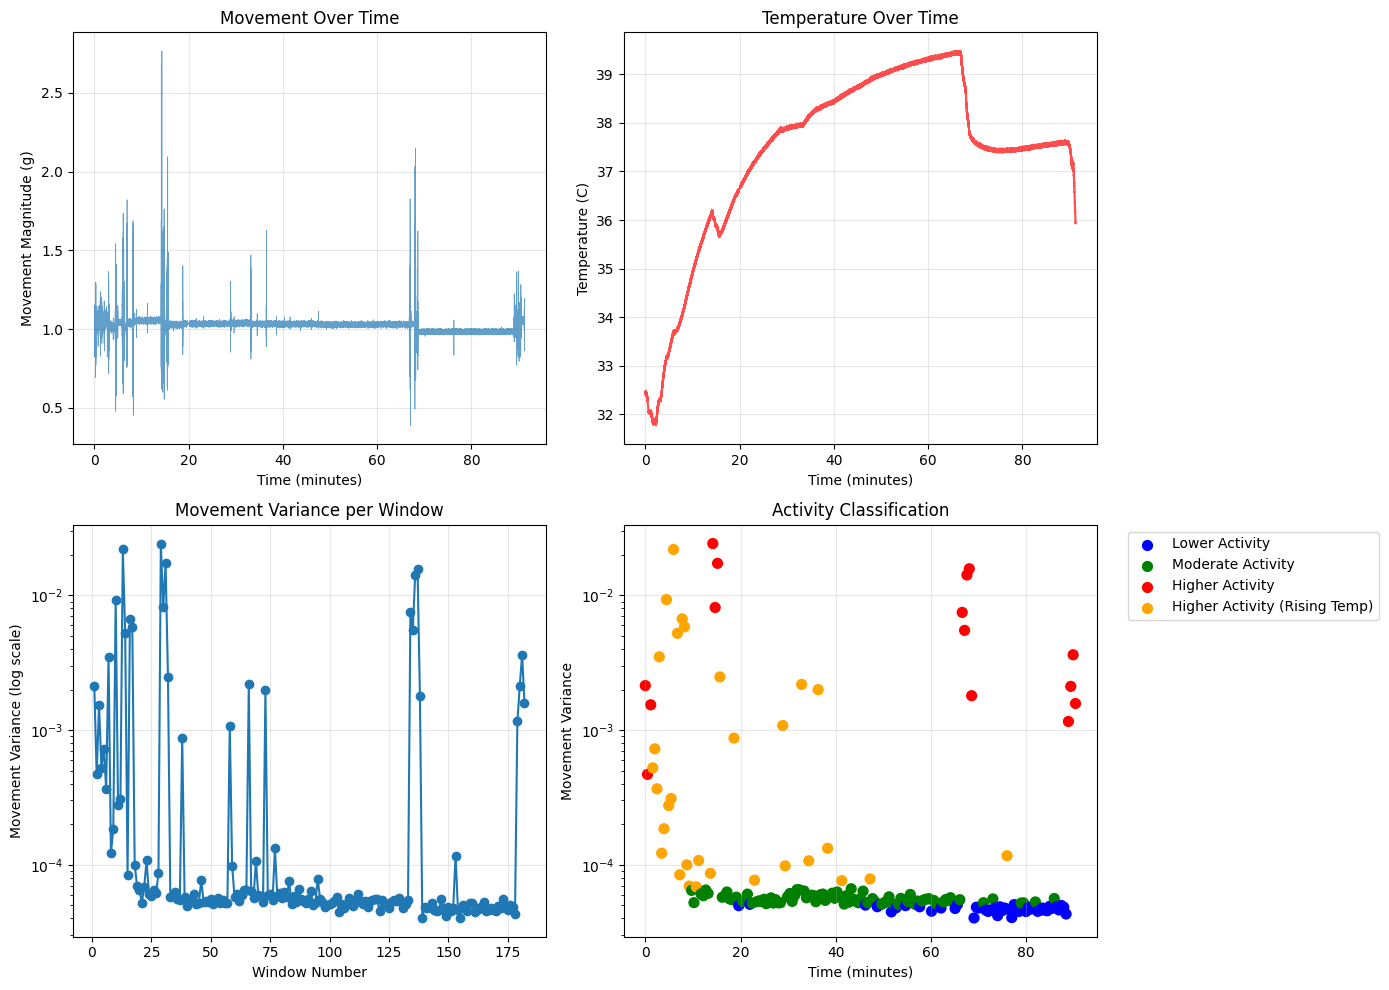


KEY NUMBERS
System monitored 91.3 minutes of continuous data
Captured 82,650 data points with no system failures
Detected 603.6x difference in movement variance patterns
Successfully implemented personalized threshold adaptation
Low movement threshold: 5.083248853063478e-05
High movement threshold: 6.792030636320592e-05


In [15]:
# Simple Gentlewake Analysis Session 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
FILENAME = 'data/merged_session_a_data.csv' # Adapt to analyze other files
WINDOW_SIZE_SECONDS = 30

def load_data(filename):
    df = pd.read_csv(filename)

    # Basic cleaning
    df = df.dropna()
    df = df[(df['x'].abs() < 50) & (df['y'].abs() < 50) & (df['z'].abs() < 50) &
            (df['temp'] > 0) & (df['temp'] < 100)]

    # Sort by timestamp before calculating relative time
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Calculate movement magnitude and time
    df['movement_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['time_min'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1000 / 60

    return df

def find_optimal_wake_time(windows_df, wake_start_ms, wake_end_ms):
    """Find optimal wakeup time (in ms) within the given wake window."""
    wake_start_min = wake_start_ms / 1000 / 60
    wake_end_min = wake_end_ms / 1000 / 60

    # Restrict to wakeup window
    wake_windows = windows_df[
        (windows_df['time_min'] >= wake_start_min) &
        (windows_df['time_min'] <= wake_end_min)
    ]

    # Prefer active phases
    optimal = wake_windows[
        wake_windows['activity_level'].str.contains('Higher Activity')
    ]

    if len(optimal) > 0:
        best_min = optimal.iloc[0]['time_min']
        print(f"Best wakeup phase: {best_min:.2f} min")
        return int(windows_df['timestamp'].iloc[0] + best_min * 60 * 1000)
    else:
        # Fallback = end of window
        print("No optimal phase found → fallback to end of window")
        return wake_end_ms

def create_windows(df, window_size_seconds):
    """30-second analysis windows and calculate movement variance"""

    # Calculate sampling rate
    duration_sec = (df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]) / 1000
    sampling_rate = len(df) / duration_sec
    samples_per_window = int(sampling_rate * window_size_seconds)

    print(f"Session: {duration_sec/60:.1f} minutes, {sampling_rate:.1f} Hz")
    print(f"Window size: {window_size_seconds} seconds ({samples_per_window} samples)")

    windows = []

    # Create windows
    for i in range(0, len(df) - samples_per_window, samples_per_window):
        window_data = df.iloc[i:i + samples_per_window]

        if len(window_data) >= samples_per_window * 0.9:
            # Calculate movement variance (key metric for your algorithm)
            movements = window_data['movement_mag'].values
            movement_variance = np.var(movements)

            # Temperature trend
            temps = window_data['temp'].values
            temp_trend = temps[-1] - temps[0]

            # Time info
            time_start = window_data['time_min'].iloc[0]

            windows.append({
                'window': len(windows) + 1,
                'time_min': time_start,
                'movement_variance': movement_variance,
                'temp_trend': temp_trend,
                'avg_temp': np.mean(temps)
            })

    return pd.DataFrame(windows), sampling_rate

def calculate_personal_thresholds(windows_df):

    variances = windows_df['movement_variance'].values

    # Personalized thresholds using percentiles
    low_threshold = np.percentile(variances, 25)   # Bottom 25% = lower activity
    high_threshold = np.percentile(variances, 75)  # Top 25% = higher activity

    print(f"\nPersonalized thresholds from this session:")
    print(f"Lower activity threshold (25th percentile): {low_threshold:.6f}")
    print(f"Higher activity threshold (75th percentile): {high_threshold:.6f}")

    return low_threshold, high_threshold

def classify_windows(windows_df, low_threshold, high_threshold):
    """Classify using personalized thresholds"""

    def classify_window(variance, temp_trend):
        if variance <= low_threshold:
            return "Lower Activity"
        elif variance >= high_threshold and temp_trend > 0:
            return "Higher Activity (Rising Temp)"
        elif variance >= high_threshold:
            return "Higher Activity"
        else:
            return "Moderate Activity"

    windows_df['activity_level'] = windows_df.apply(
        lambda row: classify_window(row['movement_variance'], row['temp_trend']), axis=1
    )

    return windows_df

def analyze_results(df, windows_df):

    # Basic session stats
    duration_min = df['time_min'].iloc[-1]
    movement_range = df['movement_mag'].max() - df['movement_mag'].min()
    temp_range = df['temp'].max() - df['temp'].min()

    print(f"\nSession Summary:")
    print(f"Duration: {duration_min:.1f} minutes")
    print(f"Data points: {len(df):,}")
    print(f"Movement range: {movement_range:.3f} g")
    print(f"Temperature range: {temp_range:.3f} C")

    # Movement variance analysis
    var_min = windows_df['movement_variance'].min()
    var_max = windows_df['movement_variance'].max()
    var_ratio = var_max / var_min if var_min > 0 else float('inf')

    print(f"\nMovement Variance Analysis:")
    print(f"Range: {var_min:.6f} to {var_max:.6f}")
    print(f"Ratio: {var_ratio:.1f}x difference")

    # Activity classification results
    activity_counts = windows_df['activity_level'].value_counts()
    print(f"\nActivity Pattern Distribution:")
    for activity, count in activity_counts.items():
        percentage = (count / len(windows_df)) * 100
        print(f"{activity}: {count} windows ({percentage:.1f}%)")

    return var_ratio

def create_plots(df, windows_df):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Movement over time
    axes[0, 0].plot(df['time_min'], df['movement_mag'], alpha=0.7, linewidth=0.5)
    axes[0, 0].set_title('Movement Over Time')
    axes[0, 0].set_xlabel('Time (minutes)')
    axes[0, 0].set_ylabel('Movement Magnitude (g)')
    axes[0, 0].grid(True, alpha=0.3)

    # Temperature over time
    axes[0, 1].plot(df['time_min'], df['temp'], 'r-', alpha=0.7)
    axes[0, 1].set_title('Temperature Over Time')
    axes[0, 1].set_xlabel('Time (minutes)')
    axes[0, 1].set_ylabel('Temperature (C)')
    axes[0, 1].grid(True, alpha=0.3)

    # Movement variance by window (log scale)
    axes[1, 0].semilogy(windows_df['window'], windows_df['movement_variance'], 'o-')
    axes[1, 0].set_title('Movement Variance per Window')
    axes[1, 0].set_xlabel('Window Number')
    axes[1, 0].set_ylabel('Movement Variance (log scale)')
    axes[1, 0].grid(True, alpha=0.3)

    # Activity classification
    activity_colors = {'Lower Activity': 'blue', 'Moderate Activity': 'green',
                      'Higher Activity': 'red', 'Higher Activity (Rising Temp)': 'orange'}
    colors = [activity_colors.get(activity, 'gray') for activity in windows_df['activity_level']]

    axes[1, 1].scatter(windows_df['time_min'], windows_df['movement_variance'], c=colors, s=50)
    axes[1, 1].set_title('Activity Classification')
    axes[1, 1].set_xlabel('Time (minutes)')
    axes[1, 1].set_ylabel('Movement Variance')
    axes[1, 1].set_yscale('log')

    # Add legend
    for activity, color in activity_colors.items():
        if activity in windows_df['activity_level'].values:
            axes[1, 1].scatter([], [], c=color, label=activity, s=50)
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def presentation_summary(var_ratio, duration_min, data_points):

    print(f"\n" + "="*50)
    print("KEY NUMBERS")
    print("="*50)

    print(f"System monitored {duration_min:.1f} minutes of continuous data")
    print(f"Captured {data_points:,} data points with no system failures")
    print(f"Detected {var_ratio:.1f}x difference in movement variance patterns")
    print(f"Successfully implemented personalized threshold adaptation")

# Run the complete analysis
def run_analysis():

    print("Gentlewake Data Analysis")
    print("="*30)

    # Load data
    df = load_data(FILENAME)

    # Create windows and calculate movement variance
    windows_df, sampling_rate = create_windows(df, WINDOW_SIZE_SECONDS)

    # Calculate personalized thresholds
    low_thresh, high_thresh = calculate_personal_thresholds(windows_df)

    # Classify using personal thresholds
    windows_df = classify_windows(windows_df, low_thresh, high_thresh)

    # Analyze results
    var_ratio = analyze_results(df, windows_df)

    # Create visualizations
    create_plots(df, windows_df)

    # Presentation summary
    presentation_summary(var_ratio, df['time_min'].iloc[-1], len(df))

    return df, windows_df

# Execute analysis
df, windows_df = run_analysis()


def infer_thresholds(windows_df):
    """
    Calculate personalized movement variance thresholds using percentiles.

    Returns a dictionary with:
    - 'low':  25th percentile (lower activity threshold)
    - 'high': 75th percentile (higher activity threshold)
    """
    variances = windows_df['movement_variance'].values
    low = np.percentile(variances, 25)
    high = np.percentile(variances, 75)

    return {"low": low, "high": high}

thresholds = infer_thresholds(windows_df)
print("Low movement threshold:", thresholds["low"])
print("High movement threshold:", thresholds["high"])

#
# wakeup_start_ms =
# wakeup_end_ms =
# = find_optimal_wake_time(windows_df, wake_start_ms, wake_end_ms)
# ("Chosen wakeup timestamp:", wakeup_timestamp_ms)